# ${\rm SU}(2)$ Heat Kernel - Diffusion & Denoising

In this notebook, we will show how we can
- use the exact score function for the ${\rm SU}(2)$ heat kernel to reverse the forward diffusion process
- train a neural network to approximate this score function and replicate the same denoising procedure
  
The idea is that we can have a direct comparison between our ML results and the analytical results, since we know the score function for the heat kernel exactly.

*Note: In more practical applications when we start with non-trivial 'training data' (i.e., give the heat equation initial conditions), we do not know the true score function for all time.*

## Setup

In [1]:
# General imports
import numpy as np
import torch

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import sun_diffusion

from sun_diffusion.heat import sun_hk, sample_sun_hk, sun_score_hk
from sun_diffusion.diffusion import VarianceExpandingDiffusionSUN
from sun_diffusion.linalg import adjoint
from sun_diffusion.sun import mat_angle, proj_to_algebra, embed_diag, matrix_exp
from sun_diffusion.canon import canonicalize_sun
from sun_diffusion.devices import set_device, summary
from sun_diffusion.utils import grab

In [3]:
set_device('cuda', 0)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float32


## Background: ${\rm SU}(2)$ Diffusion

The concepts of variance-expanding diffusion and denoising carry over (at a high level) from the Euclidean setting; however, there are now additional subtleties that arise from the fact that we are now formulating stochastic processes on a compact group manifold. Let's visualize these concepts using a single ${\rm SU}(2)$ degree of freedom.

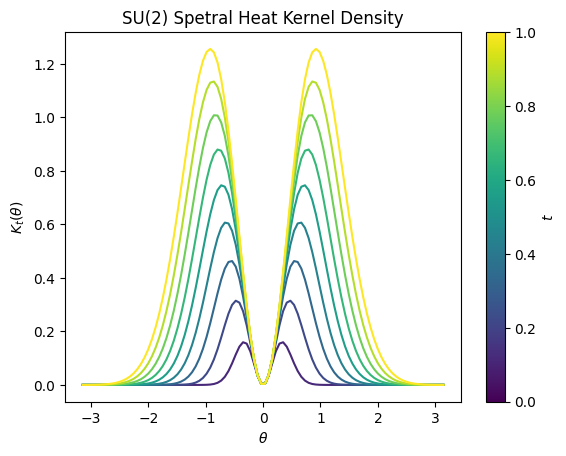

In [4]:
def visualize_sun_hk():
    xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
    times = torch.linspace(0, 1, 10)

    fig, ax = plt.subplots(1, 1)
    cmap = mpl.colormaps.get_cmap('viridis')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$K_t(\theta)$')
    ax.set_title('SU(2) Spetral Heat Kernel Density')
    for t in times:
        ax.plot(grab(xs), grab(sun_hk(xs, width=t**0.5, n_max=1)), color=cmap(grab(t)))
    time_colors = mpl.cm.ScalarMappable(mpl.colors.Normalize(times[0], times[-1]))
    cbar = fig.colorbar(time_colors, cmap=cmap, ax=ax, label='$t$')
    fig.show()

visualize_sun_hk()

We are also able to sample from the ${\rm SU}(N)$ heat kernel, though not as easily as in the Euclidean case. Our current implementation relies on *importance sampling*.

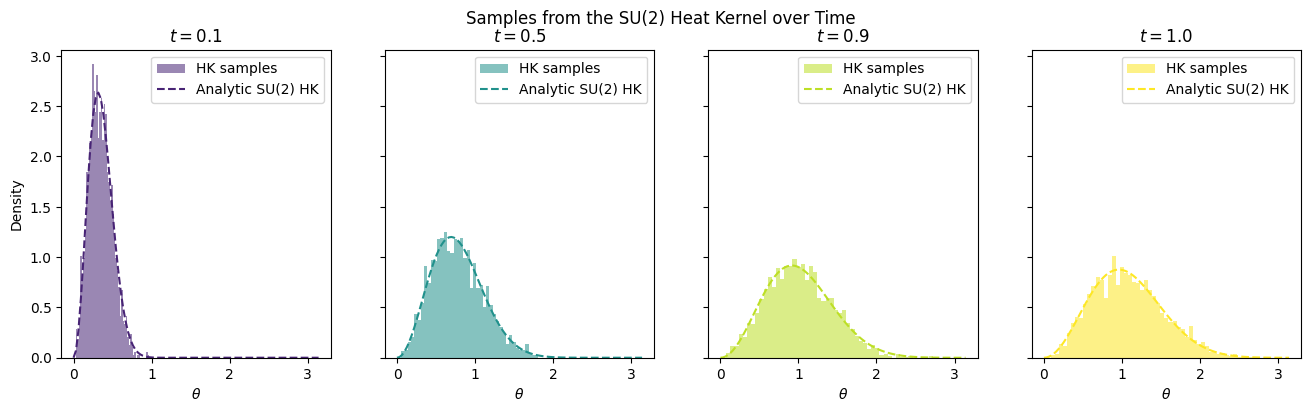

In [5]:
def test_sample_sun_hk():
    batch_size = 2048
    Nc = 2
    _U_0_re = torch.eye(Nc).repeat(batch_size, 1, 1)
    _U_0_im = torch.zeros((batch_size, Nc, Nc))
    U_0 = torch.complex(_U_0_re, _U_0_im)  # identity matrices

    # Diffusion process
    kappa = 1.1
    diffuser = VarianceExpandingDiffusionSUN(kappa)

    times = [0.1, 0.5, 0.9, 1.0]
    #xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)  
    xs = torch.linspace(0, np.pi, 100).unsqueeze(-1) # `sample_sun_hk` canonicalizes angles, so better to look at [0, pi]
    cmap = mpl.colormaps.get_cmap('viridis')

    # Compare samples from the heat kernel to the analytical heat kernel at each time
    fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
    fig.suptitle('Samples from the SU(2) Heat Kernel over Time')
    axes[0].set_ylabel('Density')
    for t, ax in zip(times, axes):
        sigma_t = diffuser.sigma_func(t)
        x_t = sample_sun_hk(batch_size, Nc=2, width=sigma_t.repeat(batch_size), n_iter=25)  # more IS iters for better sample quality at small t
        hk = sun_hk(xs, width=sigma_t, n_max=3, eig_meas=True)
        hk /= hk.sum() * (xs[1] - xs[0])
        ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.55, label='HK samples')
        ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytic SU(2) HK')
        ax.set_xlabel(r'$\theta$')
        ax.set_title(f'$t = {t}$')
        ax.legend()
    fig.show()

test_sample_sun_hk()

As opposed to sampling, we can also check that our variance-expanding diffusion process works by directly feeding in the initial configurations $U_0 = \mathbb{I}_{2 \times 2}$:

sigma(0.1): 0.3177409768104553
sigma(0.5): 0.7242947816848755
sigma(0.75): 0.8979201912879944
sigma(0.99): 1.0438283681869507


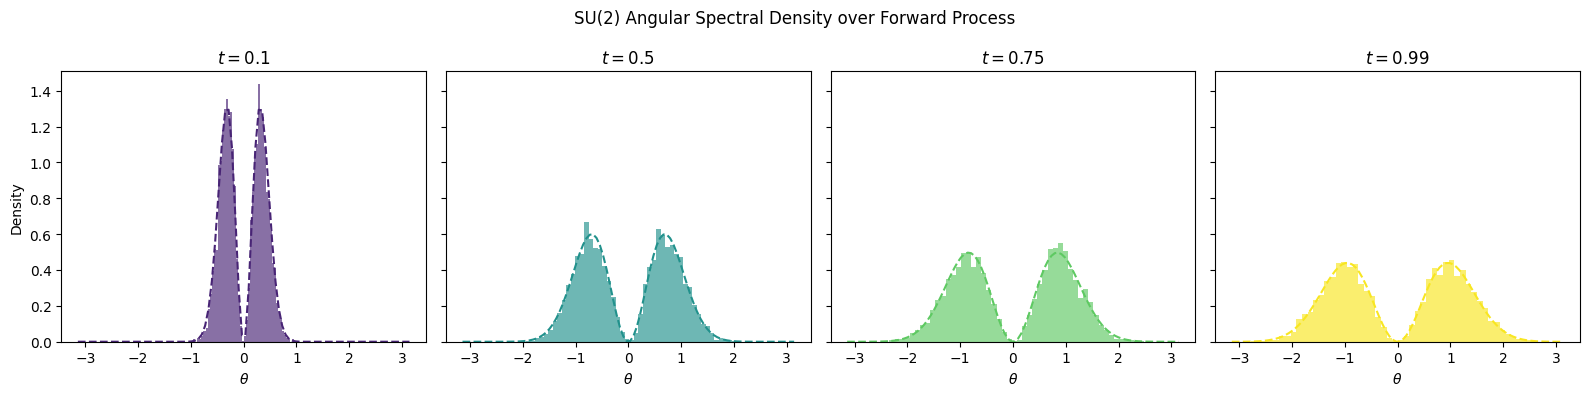

In [6]:
def visualize_sun_fwd_diffusion():
    # Create initial data (2x2 identity matrices)
    batch_size = 4096
    Nc = 2
    _U_0_re = torch.eye(Nc).repeat(batch_size, 1, 1)
    _U_0_im = torch.zeros((batch_size, Nc, Nc))
    U_0 = torch.complex(_U_0_re, _U_0_im)

    # Diffusion process
    kappa = 1.1
    diffuser = VarianceExpandingDiffusionSUN(kappa)

    times = [0.1, 0.5, 0.75, 0.99]
    xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
    cmap = mpl.colormaps.get_cmap('viridis')

    fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
    fig.suptitle('SU(2) Angular Spectral Density over Forward Process')
    axes[0].set_ylabel('Density')
    for t, ax in zip (times, axes):
        # Forward diffusion
        U_t, X_t, V = diffuser.diffuse(U_0, t=t*torch.ones((batch_size,)), n_iter=25)  # diffuse from t=0 -> t=T
        thetas, _, _ = mat_angle(U_t)
        sigma_t = diffuser.sigma_func(t)

        # Analytical HK
        hk = sun_hk(xs, width=diffuser.sigma_func(t), n_max=5, eig_meas=True)
        hk /= hk.sum() * (xs[1] - xs[0])
        print(f'sigma({t}):', sigma_t.item())
        
        # Plot snapshots
        ax.set_title(f'$t = {t}$')
        ax.set_xlabel(r'$\theta$')
        ax.hist(grab(thetas[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Diffused Samples')
        ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytical HK')
    fig.tight_layout()
    fig.show()

visualize_sun_fwd_diffusion()

## Denoising with the Exact Score Function

We have also computed the exact score function for the ${\rm SU}(N)$ heat kernel. Though it is no longer a simple linear function of the argument as it was for the Euclidean heat kernel, we may still use it to solve the reverse ODE/SDE:

In [7]:
def sample_sun_gaussian(shape):
    """Helper func to sample Gaussian matrix in the Lie algebra su(Nc)."""
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))


def denoise_backwards(U_1, diffuser, num_steps=200, solve_type='SDE'):
    trajectories = []
    dt = 1 / num_steps
    t = 1.0
    U_t = U_1.clone()
    for step in tqdm.tqdm(range(num_steps)):
        # Eigendecompose
        x_t, V, V_inv = mat_angle(U_t)

        # Get SDE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = sun_score_hk(x_t[..., :-1], width=sigma_t)

        # Integration step in reverse time
        if solve_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt  # ODE Euler step on spectra
            D = embed_diag(torch.exp(1j * x_t)).to(V)
            U_t = V @ D @ V_inv
        elif solve_type == 'SDE':
            x_t = x_t + g_t**2 * score * dt  # SDE Euler-Maruyama drift step on spectra
            D = embed_diag(torch.exp(1j * x_t)).to(V)
            U_t = V @ D @ V_inv
            U_t = matrix_exp(g_t * dt**0.5 * sample_sun_gaussian(U_t.shape)) @ U_t  # SDE noise step    
        t -= dt
        trajectories.append(U_t)
    return U_t, trajectories

  0%|          | 0/500 [00:00<?, ?it/s]

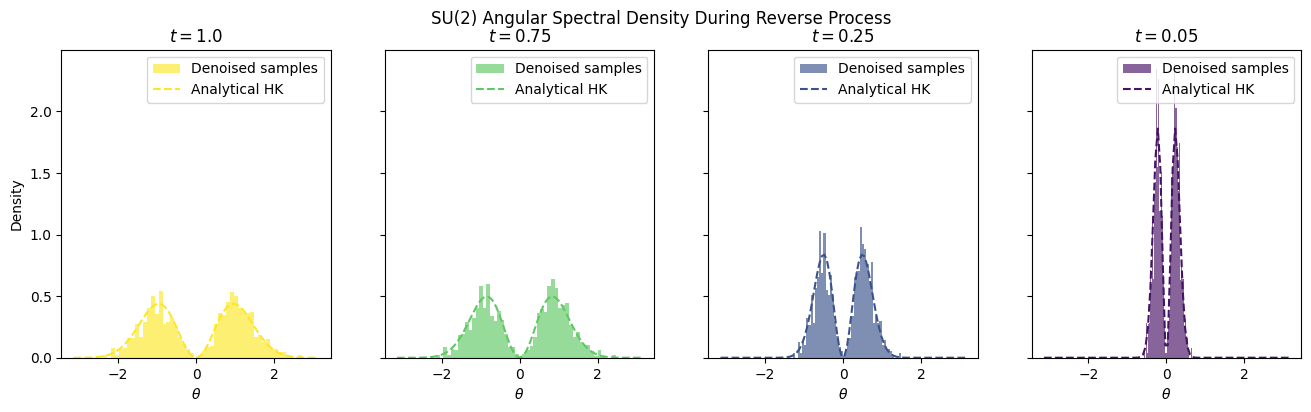

In [8]:
# Initial data: 2x2 identity matrices
num_samples = 1024
Nc = 2
_U_0_re = torch.eye(Nc).repeat(num_samples, 1, 1)
_U_0_im = torch.zeros((num_samples, Nc, Nc))
U_0 = torch.complex(_U_0_re, _U_0_im)

# Diffuse: U_0 -> U_1
kappa = 1.1
diffuser = VarianceExpandingDiffusionSUN(kappa)
U_1, _, _ = diffuser.diffuse(U_0, torch.ones(num_samples), n_iter=10)
    
# Denoise: U_1 -> U_0'
U_0, trajectories = denoise_backwards(U_1, diffuser, num_steps=500, solve_type='ODE')

# Plot reverse trajectories
times = [1.0, 0.75, 0.25, 0.05]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('SU(2) Angular Spectral Density During Reverse Process')
axes[0].set_ylabel('Density')
xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
for t, ax in zip(times, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(trajectories))
    U_t = trajectories[step]
    x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')
    
    # Analytical HK spectral density
    hk = sun_hk(xs, width=diffuser.sigma_func(t), n_max=3)
    hk /= hk.sum() * (xs[1] - xs[0])
    
    # Plot
    ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytical HK')
    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
fig.show()

## Denoising with a Trained Score Network

First we build a very simple MLP as our score network, which will input both $x$ and $t$ (for now, no special embeddings for $t$, just handle the raw time as-is)

In [9]:
class SU2ScoreNet(torch.nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),  # 1 eigenangle + time = 2
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 1))
        
    def forward(self, x_t, t):
        assert len(x_t.shape) == 2, \
            'input eigenangles shape should be [batch_size, Nc-1]'
        assert len(t.shape) == 1, \
            'times should only have a batch dimension'
        inp = torch.cat([x_t, t.unsqueeze(-1)], dim=-1)
        return self.net(inp)


def _test_su2_score_net():
    batch_size = 10
    Nc = 2
    x = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    t = torch.rand((batch_size,))
    s_t = SU2ScoreNet()(x, t)
    assert s_t.shape == x.shape, \
        '[FAILED: score net output must have same shape as input data]'
    print('[PASSED]')

_test_su2_score_net()

[PASSED]


Define the modified **score matching** loss adapted to the ${\rm SU}(N)$ group manifold

In [10]:
def score_matching_loss_sun(U_0, diffuser, score_net, tol=1e-5):
    batch_size = U_0.size(0)
    t = torch.rand(batch_size)
    t = tol + (1 - tol) * t  # stability near endpoints
    
    U_t, x_t, V = diffuser.diffuse(U_0, t, n_iter=10)
    sigma_t = diffuser.sigma_func(t)
    score = score_net(x_t[..., :-1], t) / sigma_t[:, None]
    
    true_score = sun_score_hk(x_t[..., :-1], width=sigma_t)[..., :-1]
    loss = torch.mean(sigma_t[:, None]**2 * (score - true_score)**2)
    return loss

Now do the training

In [11]:
# Make diffusion process
kappa = 1.1
score_net = SU2ScoreNet(input_dim=2, hidden_dim=64)
diffuser = VarianceExpandingDiffusionSUN(kappa)

# Make "training data"
batch_size = 256
Nc = 2
_U_0_re = torch.eye(Nc).repeat(batch_size, 1, 1)
_U_0_im = torch.zeros((batch_size, Nc, Nc))
U_0 = torch.complex(_U_0_re, _U_0_im)

# Setup training hyperparams
lr = 1e-3
epochs = 1000
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Training loop
losses = []
score_net.train()
for epoch in tqdm.tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = score_matching_loss_sun(U_0, diffuser, score_net)
    torch.nn.utils.clip_grad_norm_(score_net.parameters(), max_norm=1.0)  # Gradient clipping
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs} | Loss = {loss.item():.6f}')
    losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000 | Loss = 1.120182
Epoch 100/1000 | Loss = 0.041368
Epoch 200/1000 | Loss = 0.020661
Epoch 300/1000 | Loss = 0.011739
Epoch 400/1000 | Loss = 0.018047
Epoch 500/1000 | Loss = 0.009413
Epoch 600/1000 | Loss = 0.014424
Epoch 700/1000 | Loss = 0.013853
Epoch 800/1000 | Loss = 0.007441
Epoch 900/1000 | Loss = 0.005429


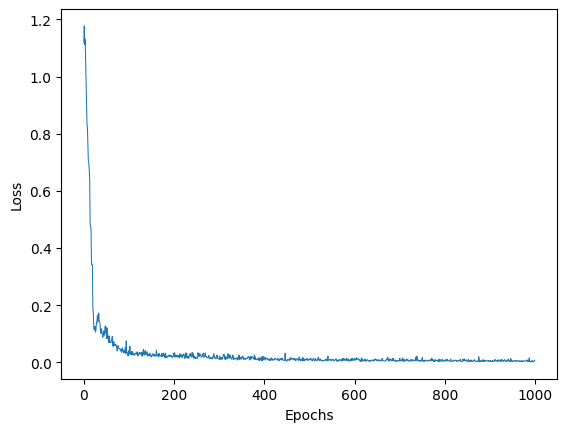

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(losses, lw=0.75)
fig.show()

To generate new samples, we define a function to sample from the diffusion model posterior using our trained score network:

In [13]:
@torch.no_grad()
def euler_sampler(U_1, score_net, diffuser, num_steps=200, solve_type='SDE'):
    trajectories = []
    dt = 1 / num_steps
    t = 1.0
    U_t = U_1.clone()
    for step in tqdm.tqdm(range(num_steps)):
        # Eigendecompose
        x_t, V, V_inv = mat_angle(U_t)

        # Get SDE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((U_t.size(0),))) / sigma_t

        # Integration step in reverse time
        if solve_type == 'ODE':
            x_t = x_t + 0.5 * g_t**2 * score * dt  # ODE Euler step on spectra
            D = embed_diag(torch.exp(1j * x_t)).to(V)
            U_t = V @ D @ V_inv
        elif solve_type == 'SDE':
            x_t = x_t + g_t**2 * score * dt  # SDE Euler-Maruyama drift step on spectra
            D = embed_diag(torch.exp(1j * x_t)).to(V)
            U_t = V @ D @ V_inv
            U_t = matrix_exp(g_t * dt**0.5 * sample_sun_gaussian(U_t.shape)) @ U_t  # SDE noise step    
        t -= dt
        trajectories.append(U_t)
    return U_t, trajectories

  0%|          | 0/500 [00:00<?, ?it/s]

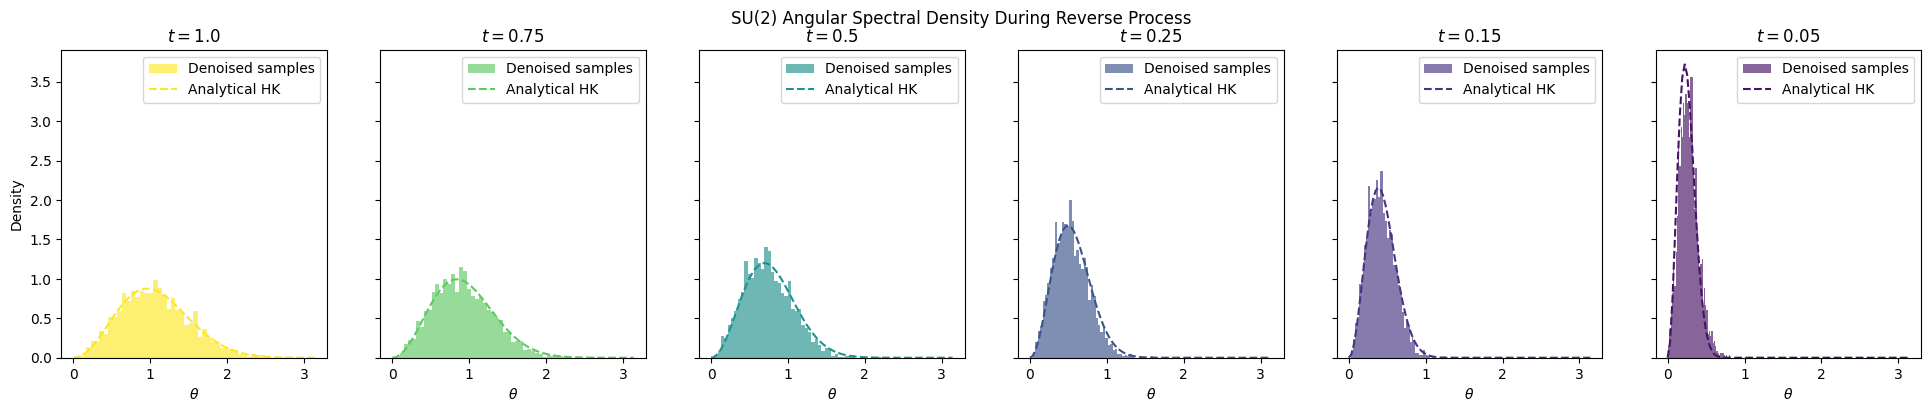

In [14]:
# Initial data: 2x2 identity matrices
num_samples = 2048
Nc = 2
_U_0_re = torch.eye(Nc).repeat(num_samples, 1, 1)
_U_0_im = torch.zeros((num_samples, Nc, Nc))
U_0 = torch.complex(_U_0_re, _U_0_im)

# Diffuse: U_0 -> U_1
U_1, _, _ = diffuser.diffuse(U_0, torch.ones(num_samples), n_iter=10)

# Denoise: U_1 -> U_0'
U_0, trajectories = euler_sampler(U_1, score_net, diffuser, num_steps=500, solve_type='ODE')

# Plot reverse trajectories
times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.05]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(4*len(times), 4), sharey=True)
fig.suptitle('SU(2) Angular Spectral Density During Reverse Process')
axes[0].set_ylabel('Density')
xs = torch.linspace(0, np.pi, 100).unsqueeze(-1)
for t, ax in zip(times, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(trajectories))
    U_t = trajectories[step]
    x_t, _, _ = mat_angle(U_t)
    x_t = canonicalize_sun(x_t)
    ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')
    
    # Analytical HK spectral density
    hk = sun_hk(xs, width=diffuser.sigma_func(t), n_max=3)
    hk /= hk.sum() * (xs[1] - xs[0])
    
    # Plot
    ax.plot(grab(xs), grab(hk), color=cmap(t), ls='--', label='Analytical HK')
    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
fig.show()

We also check the special unitarity of our generated results. Namely, that
- $U^\dagger U = \mathbb{I}$
- $\det U = 1$

In [15]:
# Check special
detU = (torch.linalg.det(U_0) * torch.linalg.det(U_0).conj()).real **0.5
assert torch.allclose(detU, torch.ones(num_samples)), \
    '[FAILED: U does NOT have unit determinant]'
print('[PASSED test of unit determinant]')

# Check unitary
UUdag = U_0 @ adjoint(U_0)
assert torch.allclose(UUdag, torch.eye(Nc).repeat(num_samples, 1, 1).to(U_0), atol=1e-4), \
    '[FAILED: U is NOT unitary]'
print('[PASSED test of unitarity]')

[PASSED test of unit determinant]
[PASSED test of unitarity]
